In [1]:
import os
os.chdir('../..')


import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad

from utils.config import load_config, apply_plotting_settings, set_seed
from src.task_1.processing_pipeline import*
from src.task_1.processing_helpers import*

warnings.filterwarnings("ignore")

In [2]:
config = load_config('config.json')
apply_plotting_settings(config)
set_seed(config)

Plotting settings applied!


# Datasets

In [3]:
data_paths = [os.path.join(config['data']['data_dir_1'], f) for f in ['internship_acquisition_list.csv', 'internship_data_matrix.csv' ]]
metadata_paths = [os.path.join(config['data']['data_dir_1'], f) for f in ['exogenous_standards.csv', 'internship_feature_metadata.csv']] 

In [4]:
dataLoader = PipelineStep(name='Data Loader', func=load_data,\
                        paths=data_paths, merge_on='sample')
metadataLoader = PipelineStep(name='Metadata Loader', func=load_data,\
                              paths=metadata_paths, merge_on=None)

In [5]:
df_data = dataLoader.run()
df_data.head()

,sample,class,id,order,batch,FT-000,FT-001,FT-002,FT-003,FT-004,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,20241106-297-Blank1,B,20241106-297-Blank1,1,1,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,20241106-297-Blank2,B,20241106-297-Blank2,2,1,0.0,0.000000,0.0,5.770641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.534493,0.0,0.0,0.0
2,20241106-297-Blank3,B,20241106-297-Blank3,3,1,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.469501,0.0,0.0,0.0
3,20241106-297-Blank4,B,20241106-297-Blank4,102,1,0.0,5.497865,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,20241106-297-Blank5,B,20241106-297-Blank5,103,1,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [6]:
print(f"There are {df_data.iloc[:,5:].isna().sum().sum()} missing values in the data matrix.")
print(f"There are initially {df_data.iloc[:,5:].shape[1]} features.")

There are 0 missing values in the data matrix.
There are initially 252 features.


In [7]:
print(f"There are {df_data['sample'].nunique()} samples from {df_data['class'].nunique()} classes and {df_data['batch'].nunique()} batches.")
print("Number of sample per batch and class")
df_data.groupby(['batch', 'class']).size()

There are 124 samples from 7 classes and 2 batches.
Number of sample per batch and class


batch  class 
1      B          6
       Dunn      27
       French    26
       LMU       26
       QC        11
       SS         1
       dQC        5
2      B          5
       QC        11
       SS         1
       dQC        5
dtype: int64

In [8]:
# We will filter out batch 2 as it does not contain any sample
df_data = df_data[df_data['batch'] == 1]

In [9]:
exogenous_std, feature_metadata = metadataLoader.run()
print(exogenous_std.head())
print("*"* 40)
print(feature_metadata.head())

  compound_id       mz  Retention_time
0         GU4   886.40             610
1         GU5  1048.45             753
2        GU14  1253.96            1500
3        GU15  1334.99            1551
****************************************
  feature          mz      mz max      mz min    mz std          rt  \
0  FT-000  359.108768  359.130591  359.090122  0.010955  543.846374   
1  FT-001  357.109546  357.130018  357.091871  0.010668  543.839157   
2  FT-002  889.649931  889.702216  889.601547  0.025552  609.099742   
3  FT-003  355.111928  355.132772  355.093653  0.010508  543.995269   
4  FT-004  888.645365  888.696941  888.600202  0.026161  609.255652   

       rt end      rt max      rt min    rt start    rt std  
0  561.270879  546.697803  539.941156  528.714227  1.683901  
1  563.021530  546.948017  540.038924  528.530311  1.662290  
2  627.717251  611.746501  606.426553  596.789046  1.324647  
3  566.951285  547.164503  540.681882  526.943213  1.609071  
4  632.996442  612.008732  

In [10]:
print("Let's print quality check injection order")
df_data[df_data['class'] == 'QC'][['class', 'sample', 'order']].sort_values(by='order')

Let's print quality check injection order


,class,sample,order
91,QC,20241106-297-QC1,12
94,QC,20241106-297-QC2,13
95,QC,20241106-297-QC3,14
96,QC,20241106-297-QC4,26
97,QC,20241106-297-QC5,38
98,QC,20241106-297-QC6,50
99,QC,20241106-297-QC7,62
100,QC,20241106-297-QC8,74
101,QC,20241106-297-QC9,86
92,QC,20241106-297-QC10,100


# 1 - Analysis

### 1.a - How many features were detected and what is the features distribution across m/z and RT ?

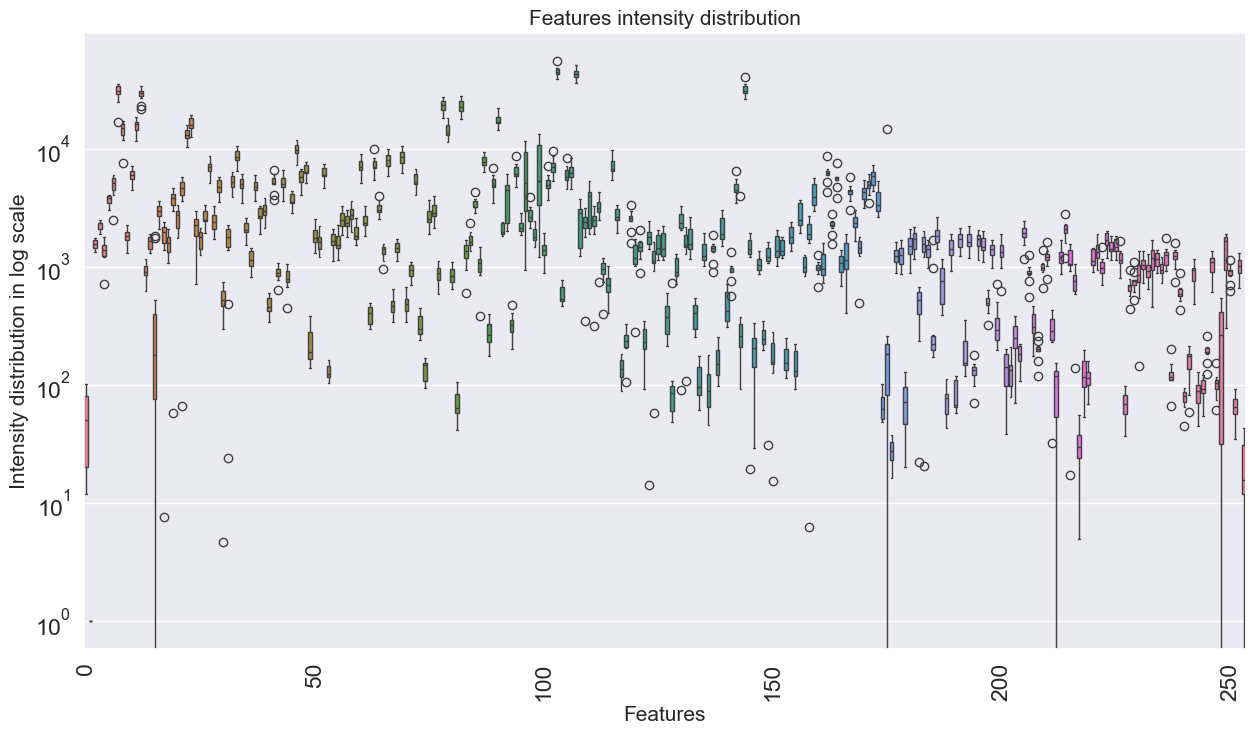

<Figure size 1500x800 with 0 Axes>

In [11]:
sns.set_theme(rc={'figure.figsize':[15,8]}, font_scale=1.5)

fig = sns.boxplot(data = df_data[df_data['class']== 'QC'])
fig.set(yscale='log')
fig.axes.set_title('Features intensity distribution',fontsize=15)
fig.set_xlabel("Features",fontsize=15)
fig.set_ylabel("Intensity distribution in log scale",fontsize=15)
fig.xaxis.set_major_locator(ticker.MultipleLocator(50))
fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rotation=90)
plt.show()
plt.savefig(os.path.join(config['results']['results_dir'], '0_features_distrib.png'))

In [12]:
featuresThreshold = PipelineStep(name='Features Threshold', func=filter_features_detection, threshold_value = 500, threshold_detect = 0.7, verbose = True)
df_data_filtered = featuresThreshold.run(df_data).reset_index(drop=True).sort_values(by='order')

Running Features Threshold on data
Removing 63 features              with low detection rate:
['FT-013', 'FT-028', 'FT-038', 'FT-047', 'FT-051', 'FT-060', 'FT-065', 'FT-068', 'FT-071', 'FT-072', 'FT-079', 'FT-086', 'FT-091', 'FT-115', 'FT-116', 'FT-120', 'FT-125', 'FT-126', 'FT-131', 'FT-132', 'FT-134', 'FT-136', 'FT-138', 'FT-141', 'FT-144', 'FT-146', 'FT-148', 'FT-151', 'FT-153', 'FT-172', 'FT-173', 'FT-174', 'FT-177', 'FT-180', 'FT-183', 'FT-186', 'FT-188', 'FT-190', 'FT-192', 'FT-195', 'FT-197', 'FT-199', 'FT-200', 'FT-201', 'FT-202', 'FT-205', 'FT-206', 'FT-209', 'FT-210', 'FT-215', 'FT-216', 'FT-217', 'FT-225', 'FT-235', 'FT-238', 'FT-239', 'FT-241', 'FT-242', 'FT-243', 'FT-245', 'FT-246', 'FT-249', 'FT-251']


So 252 - 63 ie. 189 features were correctly detected for batch 1 on QC samples. 

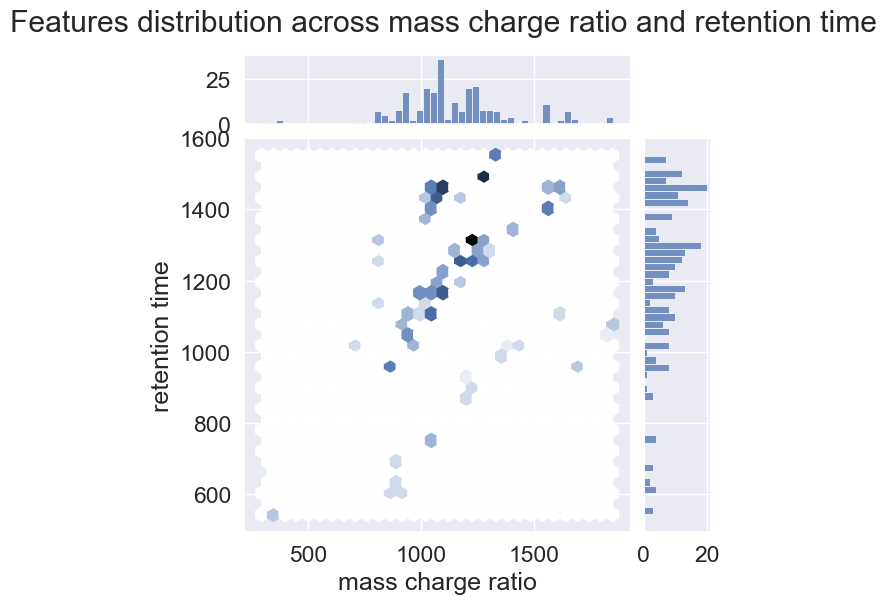

In [13]:
plot =sns.jointplot(x=feature_metadata.rename(columns={'mz': 'mass charge ratio'})['mass charge ratio'],\
                    y = feature_metadata.rename(columns={'rt': 'retention time'})['retention time'], kind='hex',\
                    marginal_kws=dict(bins=50), marginal_ticks=True, joint_kws=dict(gridsize=30))
plt.suptitle('Features distribution across mass charge ratio and retention time', y=1.02)
plt.savefig(os.path.join(config['results']['results_dir'], '0_features_mz_rt.png'))
plt.show()

### 1.b - How is the feature intensity distribution across classes ?

In [14]:
corr_mat = df_data_filtered[[col for col in df_data_filtered.columns if 'FT' in col]].corr()
corr_feats = []
feats_list = corr_mat.columns
thresh = 0.8

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[0]):
        if corr_mat.iloc[i,j] > thresh:
            corr_feats.append(feats_list[i])
corr_feats = set(corr_feats)
print(len(corr_feats))

189


All features are correlated. 

In [15]:
df_analysis = df_data_filtered.melt(id_vars=['sample', 'class', 'id', 'order', 'batch'],\
                                 var_name='feature',\
                                 value_name='intensity')

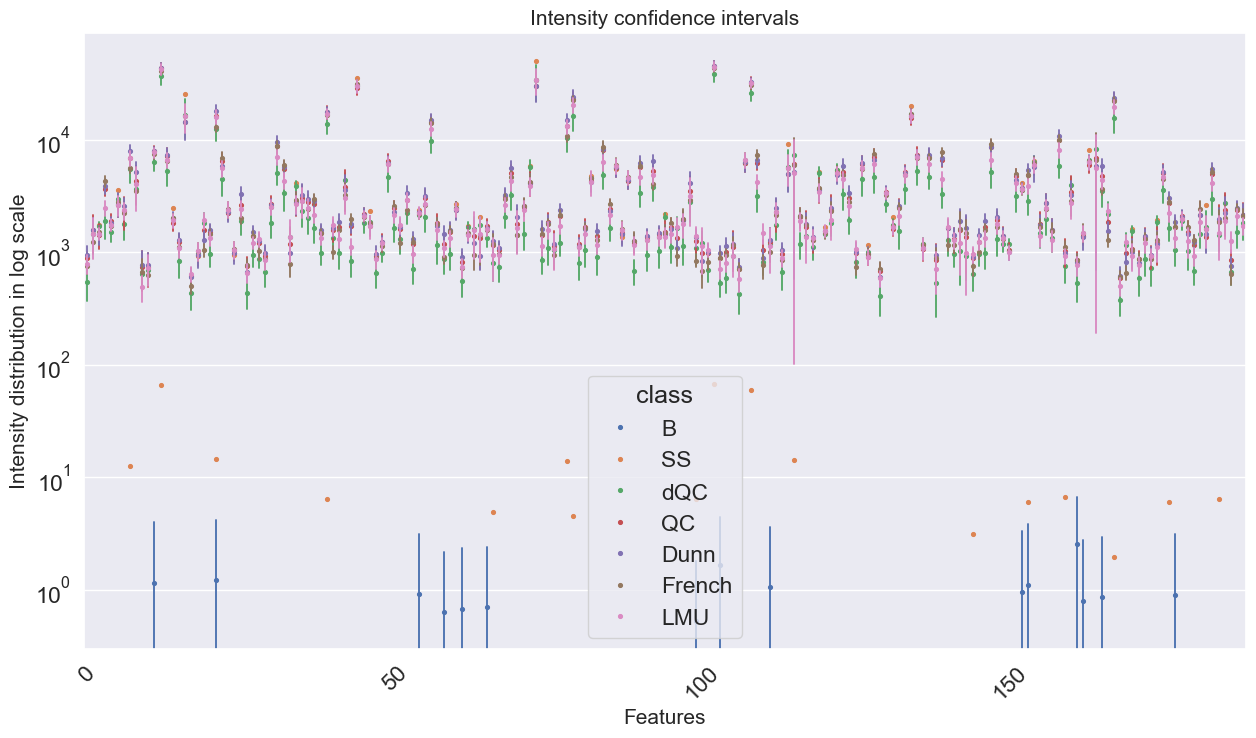

<Figure size 1500x800 with 0 Axes>

In [16]:
sns.set_theme(rc={'figure.figsize':[15,8]}, font_scale=1.5)

fig = sns.pointplot(data = df_analysis, x='feature', y='intensity',
                  hue='class', ci='sd', linestyles="", scale=0.5)
fig.set(yscale='log')
fig.axes.set_title('Intensity confidence intervals',fontsize=15)
fig.set_xlabel("Features",fontsize=15)
fig.set_ylabel("Intensity distribution in log scale",fontsize=15)
fig.xaxis.set_major_locator(ticker.MultipleLocator(50))
fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rotation=45)
plt.show()
plt.savefig(os.path.join(config['results']['results_dir'], '0_features_distrib_classes.png'))

In [17]:
df_analysis.groupby('class')['intensity'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
B,1134.0,0.083212,0.700205,0.000000,0.000000,0.000000,0.000000,9.306090
Dunn,5103.0,4235.534334,6689.588772,0.000000,1238.385010,1924.936060,4400.955438,54183.925910
French,4914.0,4028.264004,6449.904949,20.710055,1136.831129,1837.265660,4148.504007,49467.793257
LMU,4914.0,3884.459735,6508.994287,0.000000,1173.815574,1777.234737,3811.347228,54555.522451
QC,2079.0,4127.146157,6562.900410,0.000000,1224.743597,1909.624401,4319.848787,55518.049184
SS,189.0,1276.800516,5138.093487,0.000000,0.000000,0.000000,6.431994,49640.208086
dQC,945.0,3430.335608,5888.302665,169.960498,956.515806,1585.584137,3314.243958,46716.664373


### 2.a - Contamination

Contamination can be assessed using blank samples. 
First of all, if blank samples exhibit significant peaks consistently across batches, then it might highlight a contaminant.
To check peak significant, we will compare blank samples peak intensity between batches. 

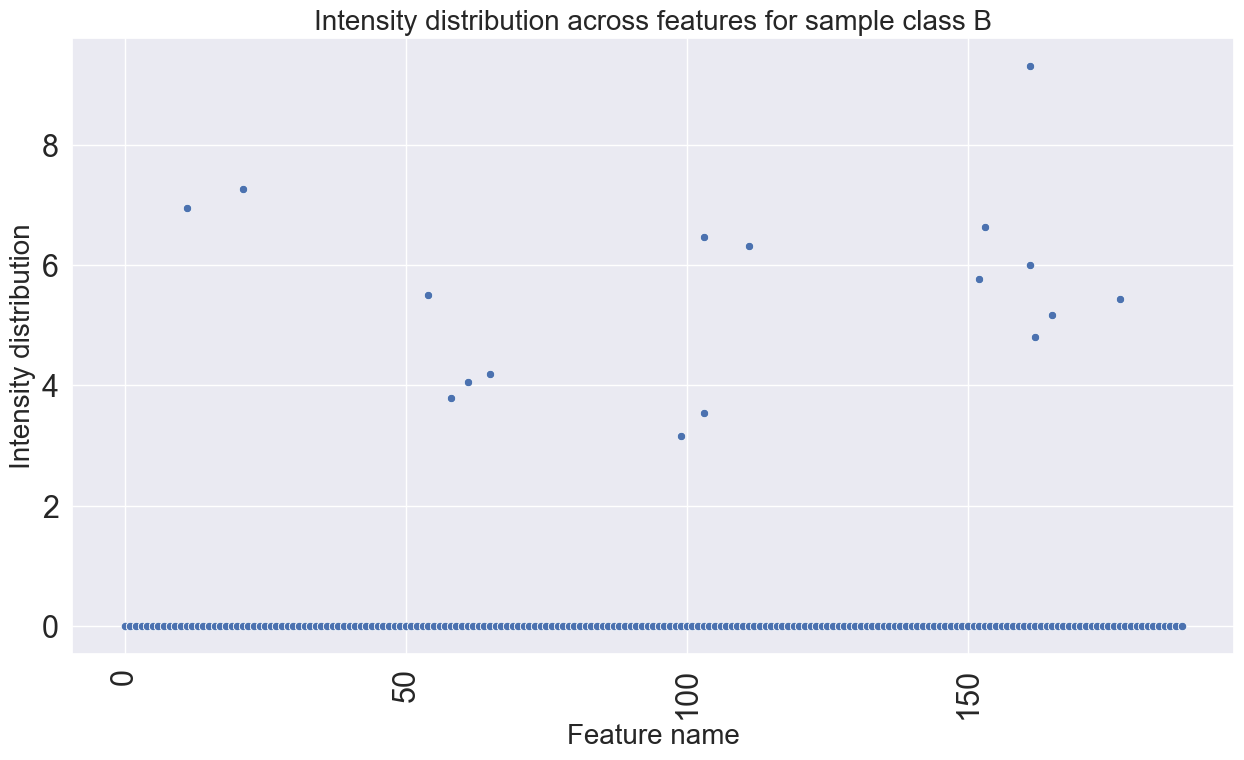

In [18]:
sns.set_theme(rc = {'figure.figsize':(15, 8)}, font_scale=2)
fig = sns.scatterplot(data = df_analysis.loc[df_analysis['class'] == 'B'],\
                   x='feature', y='intensity', palette = 'Set2')
fig.axes.set_title('Intensity distribution across features for sample class B',fontsize=20)
fig.set_xlabel("Feature name",fontsize=20)
fig.set_ylabel("Intensity distribution",fontsize=20)
#fig.set(yscale='log')
fig.xaxis.set_major_locator(ticker.MultipleLocator(50))
fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rotation=90)
plt.show()

Batches peaks heights are negligible compared to actual samples peaks heights. So we can assess that there is no contamination. 

### 3.a - Compute Coefficients of Variations for features in QC samples


In [19]:
df_QC_filtered = filter_features_variability(df_data_filtered, qc_class=['QC'], verbose=True)

Removing 28 features              with high variability :
['FT-129', 'FT-109', 'FT-019', 'FT-185', 'FT-214', 'FT-147', 'FT-090', 'FT-143', 'FT-247', 'FT-231', 'FT-015', 'FT-122', 'FT-017', 'FT-145', 'FT-213', 'FT-118', 'FT-107', 'FT-094', 'FT-121', 'FT-128', 'FT-228', 'FT-029', 'FT-181', 'FT-108', 'FT-097', 'FT-164', 'FT-156', 'FT-106']


### 3.b - Are the standards detected consistently across the experiment ?

As we have only two SS samples, we should first select features which exhibit a high intensity and we compare these features to the exogenous standards.
Then, to check consistency of standards detection in SS samples, we should filter features which exhibit a CV smaller than 40% and compare them to the exogenous standards features. 


In [20]:
print("Exogenous standard we want to detect")
exogenous_std

Exogenous standard we want to detect


,compound_id,mz,Retention_time
0,GU4,886.40,610
1,GU5,1048.45,753
2,GU14,1253.96,1500
3,GU15,1334.99,1551


In [21]:
closest_feats = dict()
for i, c in exogenous_std.iterrows():
    feature_metadata['c_dist'] = np.sqrt((feature_metadata['mz'] - c['mz'])**2 + (feature_metadata['rt'] - c['Retention_time'])**2 )
    closest_feats[c['compound_id']] = feature_metadata['feature'].iloc[feature_metadata['c_dist'].idxmin()]

print("These are the closest features to the exogenous compounds, in term of mz and rt :")
print(closest_feats)

These are the closest features to the exogenous compounds, in term of mz and rt :
{'GU4': 'FT-005', 'GU5': 'FT-010', 'GU14': 'FT-162', 'GU15': 'FT-169'}


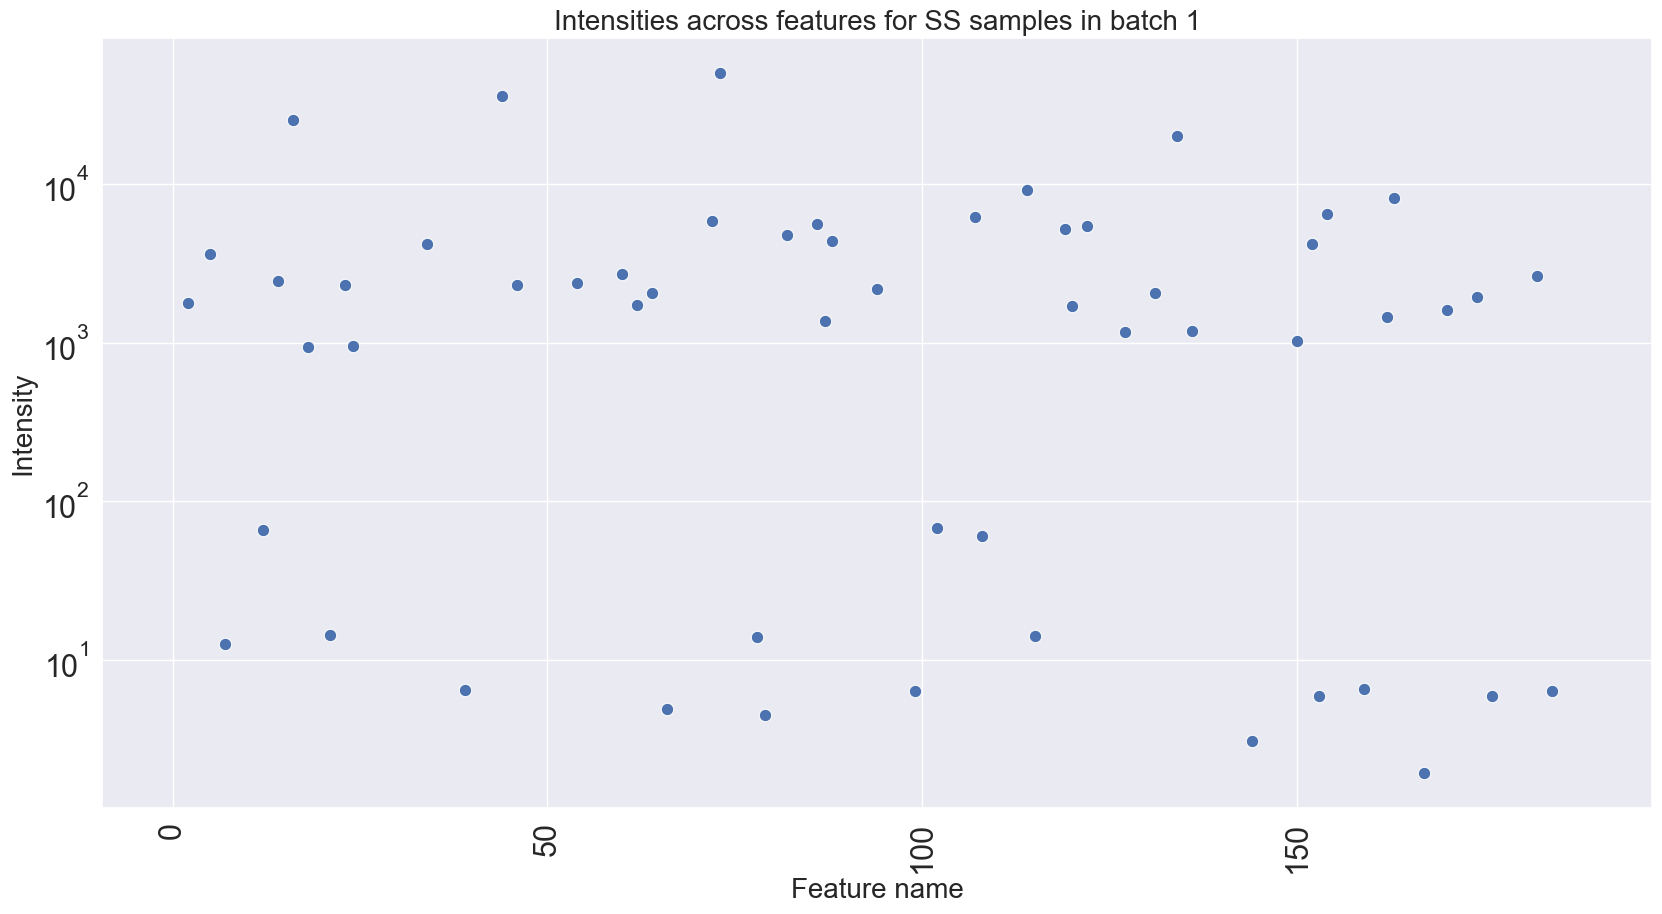

In [22]:
sns.set_theme(rc = {'figure.figsize':(20, 10)}, font_scale=2)
fig = sns.scatterplot(data = df_analysis.loc[df_analysis['class'] == 'SS'],\
                   x='feature', y='intensity', palette = 'Set2', s=80)
fig.axes.set_title('Intensities across features for SS samples in batch 1',fontsize=20)
fig.set_xlabel("Feature name",fontsize=20)
fig.set_ylabel("Intensity",fontsize=20)
fig.xaxis.set_major_locator(ticker.MultipleLocator(50))
fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.set(yscale='log')
plt.xticks(rotation=90)
plt.show()


From visual inspection, we can fix a threshold for detected features at 500 or 1000.

In [23]:
detected_compounds = df_analysis.loc[(df_analysis['class'] == 'SS') & (df_analysis['intensity'] >= 1e3)]
print(f"{set(detected_compounds['feature'].values).intersection(set(closest_feats.values()))}")

{'FT-005', 'FT-169', 'FT-010', 'FT-162'}


Features 5, 10, 162 and 169 are closest in terms of euclidean distance to exogenous compounds of interest. These features have been successfully detected with a high intensity for the first SS sample, therefore standards have been successfully detected in the first phase of the experiment.


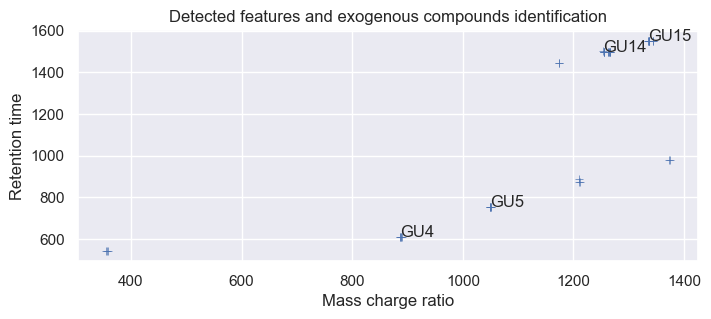

In [24]:
sns.set_theme(rc = {'figure.figsize':(8, 3)})
df_plot = detected_compounds.merge(feature_metadata, on='feature')[['feature', 'mz', 'rt']]
df_plot = pd.concat([df_plot, exogenous_std.rename(columns={'compound_id':'feature', 'Retention_time':'rt'})])
fig = sns.scatterplot(df_plot, x='mz', y='rt', marker='+')
plt.title('Detected features and exogenous compounds identification')
# Set x-axis label
plt.xlabel('Mass charge ratio')
# Set y-axis label
plt.ylabel('Retention time')

for i, point in df_plot.iterrows():
    if not 'FT' in point['feature']:
        fig.text(point['mz']+.02, point['rt'], str(point['feature']))
plt.savefig(os.path.join(config['results']['results_dir'], '0_detected_compounds.png'))

Another way to assess exogenous standard detection : plot detected features by their mass/charge and retention time along with the exogenous compounds and see whether they cluster.

In [25]:
# now we can remove unused classes
df_data_filtered = df_data_filtered.loc[df_data_filtered['class'].isin(['QC', 'Dunn', 'French', 'LMU'])].reset_index(drop=True)
df_analysis = df_analysis.loc[df_analysis['class'].isin(['QC', 'Dunn', 'French', 'LMU'])].reset_index(drop=True)

### 4.a - Are there any trends with respect to batches, order, class ?

we will focus on batch 1 only as batch 2 doesn't contain any samples.

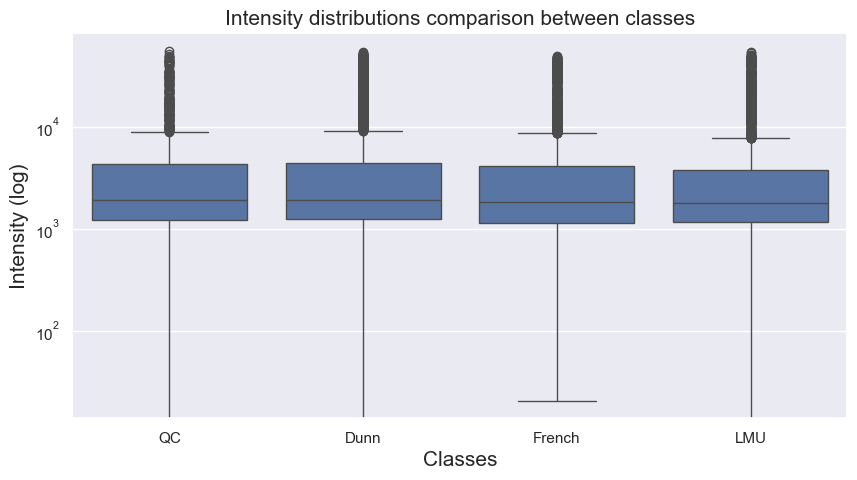

In [26]:
sns.set(rc = {'figure.figsize':(10, 5)})
fig = sns.boxplot(df_analysis, x='class', y='intensity', order=[ 'QC', 'Dunn', 'French', 'LMU'])
fig.axes.set_title('Intensity distributions comparison between classes',fontsize=15)
fig.set_xlabel("Classes",fontsize=15)
fig.set_ylabel("Intensity (log)",fontsize=15)
fig.set_yscale('log')
plt.savefig(os.path.join(config['results']['results_dir'], '0_intensity_distribution_per_class.png'))

Class-level intensity distributions are heavy-tailed distributions. We observe that intensities recorded in batch 2 for quality check samples are much lower than in batch 1, which encourages us to only consider batch 1 for QC / samples intensity comparison.

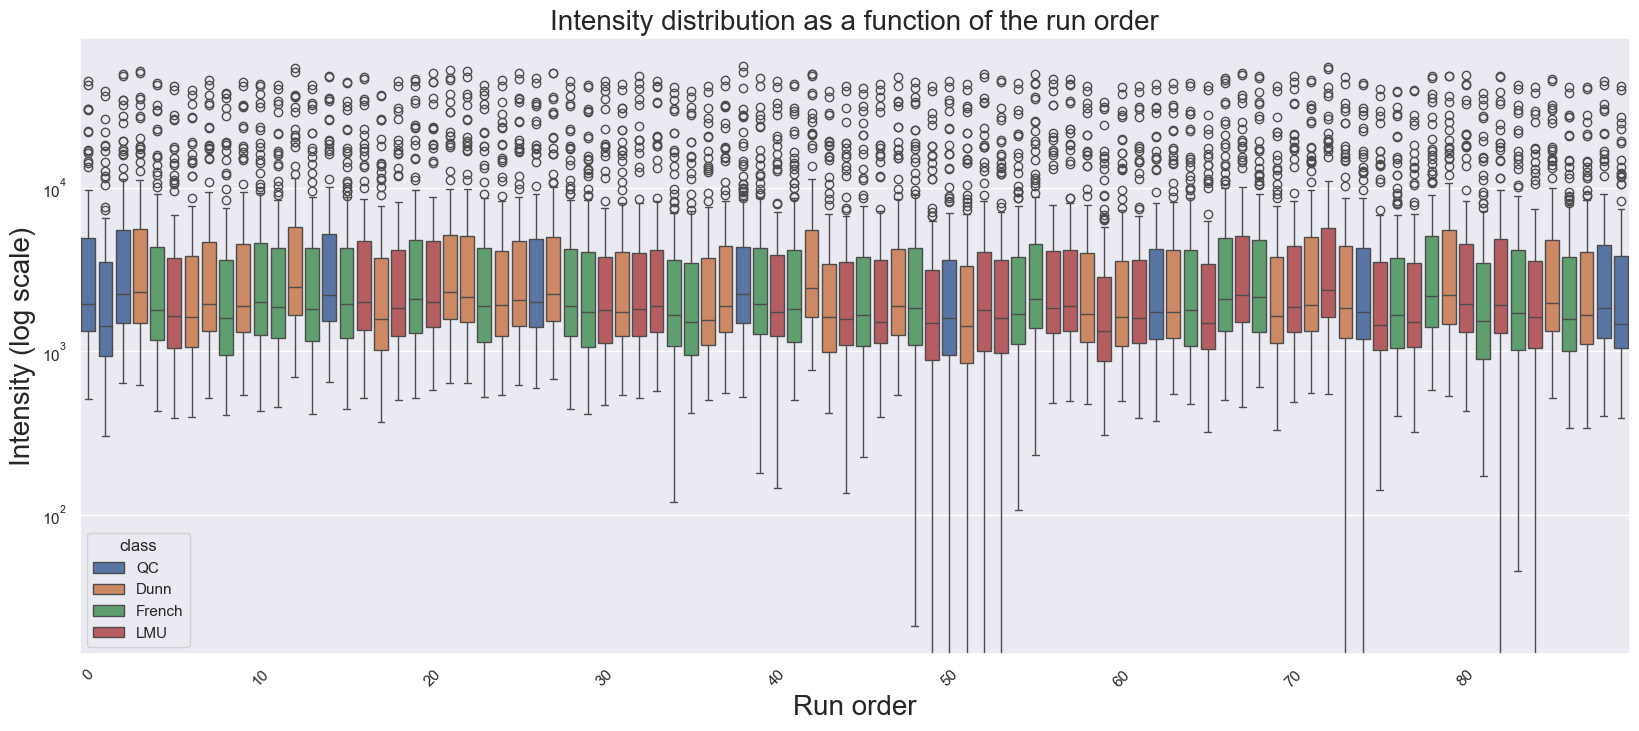

In [27]:
sns.set(rc = {'figure.figsize':(20, 8)})
fig = sns.boxplot(df_analysis, x='order', y='intensity', hue='class')
fig.axes.set_title('Intensity distribution as a function of the run order',fontsize=20)
fig.set_xlabel("Run order",fontsize=20)
fig.set_ylabel("Intensity (log scale)",fontsize=20)
fig.set_yscale('log')
fig.xaxis.set_major_locator(ticker.MultipleLocator(10))
fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rotation=45)
plt.savefig(os.path.join(config['results']['results_dir'], '0_intensity_distribution_runorder.png'))

From the above plot, we can notice a variability of the intensity distributions along the experiment and an intensity distribution shift for run orders around run order 50. As it affected both quality checks and samples, we can assume it is due to technical variability.

From previous works (1), (2), we can expect signal drifts in peak intensities as a function of the run order. These works suggest using QC metabolite intensities to correct for the technical drift. They also came up with spline or exponential curve fitting to QC data to derive correction coefficients. 

(1) [Evaluation and correction of injection order effects in LC-MS/MS based targeted metabolomics](https://www.sciencedirect.com/science/article/pii/S1570023222004184#s0010)

(2) [Instrumental Drift in Untargeted Metabolomics: Optimizing Data Quality with Intrastudy QC Samples](https://pmc.ncbi.nlm.nih.gov/articles/PMC10222478/)

(3)[Riquelme, G.; Zabalegui, N.; Marchi, P.; Jones, C.M.; Monge, M.E. A Python-Based Pipeline for Preprocessing LC–MS Data for Untargeted Metabolomics Workflows. Metabolites 2020, 10, 416, doi:10.3390/metabo10100416.](https://tidyms.readthedocs.io/en/latest/)

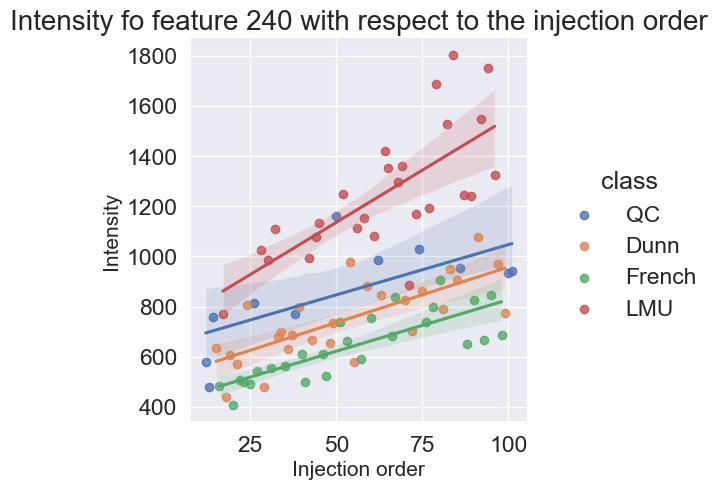

In [28]:
df_plot = df_analysis[(df_analysis['feature'] == 'FT-240')]
sns.set_theme(rc = {'figure.figsize':(10, 5)}, font_scale=1.5)
sns.lmplot(data=df_plot, x="order", y="intensity", hue="class")
plt.title('Intensity fo feature 240 with respect to the injection order',fontsize=20)
plt.xlabel("Injection order",fontsize=15)
plt.ylabel("Intensity",fontsize=15)
plt.savefig(os.path.join(config['results']['results_dir'], 'intensity_feature240_runorder.png'))
#fig.set_yscale('log')

This drift can easily be seen for feature 240 for instance. Indeed, we can guess there is a positive linear correlation between injection order and intensity. 
However, this linear relationship cannot be applied to all features.

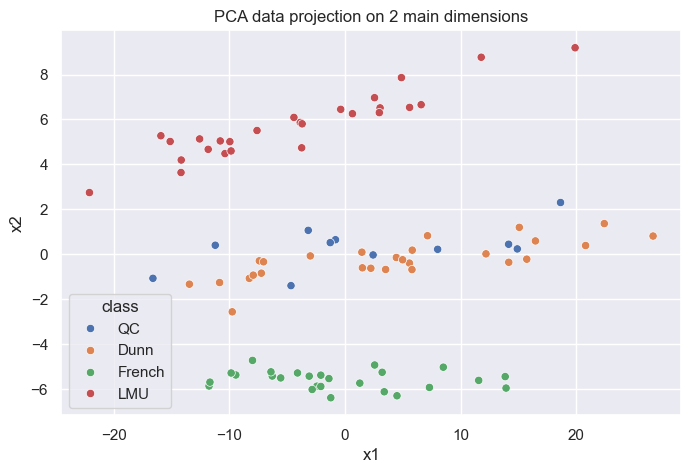

In [29]:
visualizer = PipelineStep(name='PCA projection',
                          func = pca, standardize=True)

_ = visualizer.run(df_data_filtered)

Previous works suggest PCA dimensionality reduction to visualize how samples and quality checks cluster on the 2-main components graph. We observe that QC samples do not cluster tightly on the plot, indicating technical variation.

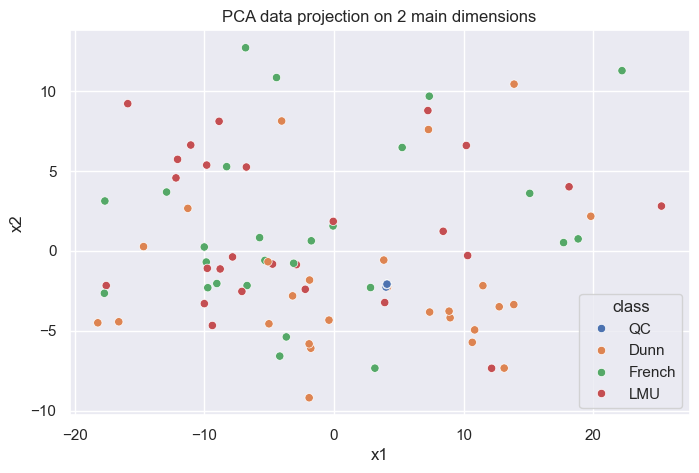

In [30]:
from src.task_1.batch_corrector import BatchCorrector
batch_corrector = BatchCorrector()
batch_corrector.min_detection_rate = 0.7
batch_corrector.frac_loess = 0.36
batch_corrector.sample_classes = ['Dunn', 'French', 'LMU']

pip = Pipeline()
pip.add([batch_corrector, visualizer])
df_data_corrected = pip.run(df_data_filtered)


After intra batch effect correction, we notice that QC samples cluster tighter. Let's see how much this reduced the CV of features.

In [31]:
_ = filter_features_variability(df_data_corrected, qc_class=['QC'], verbose=True)

Removing 2 features              with high variability :
['FT-145', 'FT-181']


### 5.b Computing the D-ratio

The D-ratio monitors how much of the total observed variation is due to technical variation. Preferred D-ratio for features are below 50%, with the metabolite intensity standard deviation across samples is much larger than the metabolite standard deviation for QC samples.
If the distribution of data is not Gaussian then, the raw data either needs to be mathematically transformed, e.g. log10, before calculating the D-ratio or a non-parametric alternative used, (1).

D-ratio is computed on batch 1 only.

(1)[Guidelines and considerations for the use of system suitability and quality control samples in mass spectrometry assays applied in untargeted clinical metabolomic studies](https://link.springer.com/article/10.1007/s11306-018-1367-3#Sec6)

In [32]:
sample_classes = ['Dunn', 'French', 'LMU']
df_dratio_filtered = filter_features_dratio(df_data_filtered, sample_classes=sample_classes, verbose=True)

Removing 187 features               with low biological information :
['FT-040', 'FT-129', 'FT-167', 'FT-096', 'FT-018', 'FT-109', 'FT-025', 'FT-019', 'FT-185', 'FT-214', 'FT-085', 'FT-105', 'FT-113', 'FT-007', 'FT-234', 'FT-006', 'FT-237', 'FT-139', 'FT-123', 'FT-223', 'FT-021', 'FT-104', 'FT-161', 'FT-158', 'FT-024', 'FT-227', 'FT-196', 'FT-208', 'FT-230', 'FT-073', 'FT-031', 'FT-070', 'FT-147', 'FT-154', 'FT-110', 'FT-056', 'FT-114', 'FT-222', 'FT-088', 'FT-016', 'FT-052', 'FT-090', 'FT-221', 'FT-010', 'FT-093', 'FT-023', 'FT-069', 'FT-211', 'FT-092', 'FT-059', 'FT-053', 'FT-014', 'FT-034', 'FT-001', 'FT-074', 'FT-077', 'FT-048', 'FT-218', 'FT-194', 'FT-166', 'FT-042', 'FT-150', 'FT-143', 'FT-247', 'FT-082', 'FT-231', 'FT-229', 'FT-062', 'FT-041', 'FT-015', 'FT-117', 'FT-157', 'FT-005', 'FT-187', 'FT-184', 'FT-122', 'FT-033', 'FT-020', 'FT-076', 'FT-224', 'FT-191', 'FT-168', 'FT-182', 'FT-064', 'FT-026', 'FT-162', 'FT-119', 'FT-165', 'FT-236', 'FT-045', 'FT-063', 'FT-030', 'FT-066',

Without monitoring technical variability, we would remove all features. With intra batch correction, we remove one feature only.

In [33]:
df_dratio_filtered = filter_features_dratio(df_data_corrected, sample_classes=sample_classes, verbose=True)

Removing 1 features               with low biological information :
['FT-145']
